**MIMIC-IV Feature extraction from postgresql**

## Setup

In [77]:
%pip install psycopg2-binary --quiet
%pip install --upgrade jupyterlab jupyterlab-git --quiet
#!pip install pydantic --quiet
%pip install tqdm --quiet
%pip install scikit-learn --quiet
%pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql

In [3]:
postgres_ip = '127.0.0.1'
db = 'mimic'
schema = 'mimiciv_hosp'
port = 5432 # default
username = 'postgres'
password = 'miriam8518'

In [4]:
connection = pg.connect(f"host={postgres_ip} dbname={db} user={username} password={password}")

# Read the data from postgresql


In [6]:
sql_query = f"""
                WITH diagnoses AS (
                  SELECT 
                    dx.*, 
                    di.long_title 
                  FROM 
                    {schema}.diagnoses_icd dx 
                    INNER JOIN {schema}.d_icd_diagnoses di ON dx.icd_code = di.icd_code 
                  WHERE dx.icd_version = 10 AND di.icd_version = dx.icd_version
                ), 
                diagnoses_with_year AS (
                  SELECT 
                    date_part('year', admittime) event_year, 
                    a.hadm_id, 
                    a.subject_id, 
                    d.icd_code, 
                    d.icd_version, 
                    d.long_title, 
                    a.admission_type, 
                    d.seq_num 
                  FROM 
                    diagnoses d 
                    INNER JOIN {schema}.admissions a ON d.hadm_id = a.hadm_id
                ), 
                admission_with_age AS (
                  SELECT 
                    ad.subject_id, 
                    ad.hadm_id, 
                    ad.admittime, 
                    ad.admission_type, 
                    EXTRACT(
                      YEAR 
                      FROM 
                        ad.admittime
                    ) - pa.anchor_year + pa.anchor_age AS age 
                  FROM 
                    {schema}.admissions ad 
                    INNER JOIN {schema}.patients pa ON ad.subject_id = pa.subject_id
                ), 
                final_feature_extraction AS (
                  SELECT 
                    a.subject_id, 
                    a.hadm_id, 
                    a.age, 
                    a.admittime, 
                    a.admission_type, 
                    d.event_year, 
                    d.icd_code, 
                    d.icd_version, 
                    d.long_title, 
                    d.seq_num 
                  FROM 
                    diagnoses_with_year d 
                    INNER JOIN admission_with_age a ON d.hadm_id = a.hadm_id
                ) 
                SELECT 
                  * 
                FROM 
                  final_feature_extraction
                ORDER BY 
                  admittime ASC 
                """

In [7]:
diagnosis_df = psql.read_sql(sql_query, connection)

C:\Users\Miriam\AppData\Local\Temp\ipykernel_43848\4229716797.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  diagnosis_df = psql.read_sql(sql_query, connection)


In [8]:
diagnosis_df['age'].max()

93.0

In [9]:
diagnosis_df['event_year'].max()

2201.0

In [10]:
len(set(diagnosis_df['icd_code']))

734

In [23]:
import pandas as pd
import requests

# Download the CSV file from the URL and save it to a local file
icd_aggegator_df = pd.read_csv('ccs_dx_icd10cm_2018_1.csv')
icd_aggegator_df.columns = icd_aggegator_df.columns.str.replace("'", "")
icd_aggegator_df = icd_aggegator_df.applymap(lambda x: x.replace("'", ""))

# Create a dictionary mapping ICD-10-CM codes to CCS categories
icd10_ccs_mapping = icd_aggegator_df.set_index('ICD-10-CM CODE')['CCS CATEGORY'].to_dict()
temp_icd_codes = set(diagnosis_df['icd_code']) 

In [24]:
def icd_codes_preprocessing(icd_code: str, with_icd10_codes_aggregation=False):
    icd_code = icd_code.strip()
    if with_icd10_codes_aggregation:
        icd_code = icd10_ccs_mapping[icd_code] if icd_code in icd10_ccs_mapping else icd_code
    return icd_code

diagnosis_df['icd_code'] = diagnosis_df['icd_code'].apply(lambda icd_code: icd_codes_preprocessing(icd_code, with_icd10_codes_aggregation=True))

In [25]:
counter = 0
missing_elements = []

for element in temp_icd_codes:
    element = element.strip()
    if element not in icd10_ccs_mapping:
        counter += 1
        missing_elements.append(element)
print(f'Number of elements in the set that are not in the dictionary: {counter}')
missing_elements[:10]

Number of elements in the set that are not in the dictionary: 0


[]

In [26]:
print(f'The number of unique patients is: {len(set(diagnosis_df.subject_id))}')


The number of unique patients is: 44


In [27]:
print(f'The number of unique diagnosis codes after aggregation is: {len(set(diagnosis_df.icd_code))}')


The number of unique diagnosis codes after aggregation is: 173


In [28]:
import os
if not os.path.exists('data/icd10'):
    os.makedirs('data/icd10')

diagnosis_df.to_csv(f'data/icd10/mimic_iv_icd10_features_with_aggregations.csv')

# Convert to `BEHRT` input format

`BEHRT` example `code` input: `['disease1', 'SEP', 'medication1', 'medication2', 'disease2', 'SEP', 'disease3', 'SEP', 'disease4', 'medication1', 'SEP']`

## Create the dataset

In [29]:
def build_behrt_visit_codes(df: pd.DataFrame, hadm_id: int, visit_separator: str):
    visit_df = df[df['hadm_id'] == hadm_id]
    #visit_df = visit_df.sort_values(by=['seq_num'])
    concept_ids, ages, years =  list(visit_df['icd_code']), list(visit_df['age']), list(visit_df['event_year'])
    concept_ids.append(visit_separator)
    ages.append(ages[-1])
    years.append(years[-1])
    return concept_ids, ages, years

In [30]:
print(build_behrt_visit_codes(diagnosis_df, hadm_id=tuple(diagnosis_df['hadm_id'].sample())[0], visit_separator='SEP'))


(['157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157', '157

In [31]:
def build_behrt_codes_for_person(person_id: int, visit_separator: str):
    person_codes = []
    person_ages = []
    person_years = []
    
    person_visit_hadm_ids = list(dict.fromkeys((diagnosis_df[diagnosis_df['subject_id'] == person_id]['hadm_id'])))
    for person_visit_id in person_visit_hadm_ids:
        visit_codes, visit_ages, visit_years = build_behrt_visit_codes(df=diagnosis_df, hadm_id=person_visit_id, visit_separator=visit_separator)
        person_codes.extend(visit_codes)
        person_ages.extend(visit_ages)
        person_years.extend(visit_years)
    return person_codes, person_ages, person_years

In [32]:
print(build_behrt_codes_for_person(person_id=tuple(diagnosis_df['subject_id'].sample())[0], visit_separator='SEP'))

(['110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110', '110

In [33]:
from tqdm import tqdm

def build_behrt_codes_dataset(df: pd.DataFrame, visit_separator: str):
    person_ids = list(dict.fromkeys(df['subject_id']))
    ds_rows = []
    for person_id in tqdm(person_ids, desc = 'building ds from patients Progress Bar', disable=True):
        person_condition_codes, person_condition_ages, person_condition_years = build_behrt_codes_for_person(person_id, visit_separator)
        person_data = {'person_id': person_id, 'code': person_condition_codes, 'age': person_condition_ages, 'year': person_condition_years}
        ds_rows.append(person_data)
    return pd.DataFrame(ds_rows)

In [34]:
input_dataset = build_behrt_codes_dataset(diagnosis_df, visit_separator='SEP')

In [35]:
input_dataset.to_csv('data/icd10/mimic_iv_behrt_with_aggregations_ds.csv')

In [36]:
# train-test split
from sklearn.model_selection import train_test_split

input_dataset_train_df, input_dataset_test_df = train_test_split(input_dataset, test_size=0.2)
input_dataset_train_df.to_csv("data/icd10/mimic_iv_behrt_with_aggregations_train_ds.csv", index=False)
input_dataset_test_df.to_csv("data/icd10/mimic_iv_behrt_with_aggregations_test_ds.csv", index=False)


## Build `token2index` (`token2idx.json` file)

In [37]:
TOKEN2INX_FILE_PATH = '../../BEHRT/my_data/mimic_iv_icd10_with_aggregations_token2idx.json'

In [38]:
from typing import List 

def get_all_codes(df: pd.DataFrame, codes_to_ignore: List[str]) -> List[str]:
    codes = []
    for df_list_codes in list(df['code']):
        codes.extend(df_list_codes)
    return list(set(codes) - set(codes_to_ignore))

In [39]:
print(f'number of unique codes: {len(get_all_codes(df=input_dataset, codes_to_ignore=[])) - 5}')

number of unique codes: 169


In [40]:
from typing import Dict
import json
from collections import OrderedDict

from typing import List 

def get_all_codes(df: pd.DataFrame, codes_to_ignore: List[str]) -> List[str]:
    codes = []
    for df_list_codes in list(df['code']):
        codes.extend(df_list_codes)
    return list(set(codes) - set(codes_to_ignore))

def get_bert_tokens() -> Dict[str, int]:
    return {
      "PAD": 0,
      "UNK": 1,
      "SEP": 2,
      "CLS": 3,
      "MASK": 4,
    }
    
def build_token2index_dict(df: pd.DataFrame) -> Dict[str, int]:
    token2inx_dict = get_bert_tokens()
    next_index = max(token2inx_dict.values()) + 1
    
    codes = get_all_codes(df= df, codes_to_ignore=token2inx_dict.keys())
    for code in codes:
        token2inx_dict[str(code)] = next_index
        next_index += 1
    return token2inx_dict

def create_token2index_file(df: pd.DataFrame, output_file_path: str):
    token2inx_dict = build_token2index_dict(df= df)
    with open(output_file_path, 'w') as f:
        json.dump(token2inx_dict, f)
        print(f'token2inx was created, path={output_file_path}')
        

In [50]:
# TOKEN2INX_FILE_PATH = '../../BEHRT/my_data/token2idx.json'
print(TOKEN2INX_FILE_PATH)
create_token2index_file(df= input_dataset, output_file_path=TOKEN2INX_FILE_PATH)


../../BEHRT/my_data/token2idx.json
token2inx was created, path=../../BEHRT/my_data/token2idx.json


In [52]:

!python ../../BEHRT/preprocess/bert_vocab_builder.py {TOKEN2INX_FILE_PATH} mimic_iv_icd10_with_aggregations_vocab.pkl

{'PAD': 0, 'UNK': 1, 'SEP': 2, 'CLS': 3, 'MASK': 4, '650': 5, '15': 6, '212': 7, '93': 8, '249': 9, '257': 10, '140': 11, '256': 12, '160': 13, '142': 14, '157': 15, '255': 16, '118': 17, '155': 18, '10': 19, '48': 20, '134': 21, '6': 22, '253': 23, '64': 24, '250': 25, '7': 26, '86': 27, '125': 28, '128': 29, '99': 30, '215': 31, '2610': 32, '104': 33, '3': 34, '230': 35, '39': 36, '211': 37, '2616': 38, '88': 39, '653': 40, '229': 41, '159': 42, '84': 43, '60': 44, '54': 45, '152': 46, '2611': 47, '661': 48, '153': 49, '98': 50, '45': 51, '122': 52, '135': 53, '246': 54, '131': 55, '233': 56, '245': 57, '110': 58, '89': 59, '234': 60, '141': 61, '47': 62, '2614': 63, '59': 64, '94': 65, '145': 66, '102': 67, '108': 68, '63': 69, '97': 70, '87': 71, '139': 72, '248': 73, '207': 74, '136': 75, '4': 76, '57': 77, '670': 78, '251': 79, '143': 80, '657': 81, '206': 82, '239': 83, '37': 84, '237': 85, '23': 86, '244': 87, '85': 88, '130': 89, '121': 90, '133': 91, '148': 92, '164': 93, '14

## Build BEHRT downstream task dataset. 
`Next visit prediction`: for each patient, we randomally choose `j` index (where `3<j<number_of_visits`).

Then we train on the first `j` visits, and test on `j+1` visit.

In [55]:
from typing import List, Dict
from random import randrange


def split_list(list_to_split: List, separator: str):
    list_after_split = []
    current_list = []
    for element in list_to_split:
        current_list.append(element)
        if element == separator:
            list_after_split.append(current_list)
            current_list = []
    return list_after_split

def split_visits(codes: List, ages: List, years: List, visit_index: int, separator: str):
    codes_after_split = split_list(list_to_split=codes, separator=separator)
    train_codes, test_codes = codes_after_split[:visit_index + 1], codes_after_split[visit_index + 1]
    train_codes = [item for sublist in train_codes for item in sublist]
    
    #train_codes_num = sum([len(visit_codes) for visit_codes in train_codes])
    train_codes_num = len(train_codes)
    test_codes_num = len(test_codes) # test_codes is not a nested list, because it contains only one visit details.

    train_ages, test_ages = ages[:train_codes_num], ages[train_codes_num:train_codes_num + test_codes_num]
    train_years, test_years = years[:train_codes_num], ages[train_codes_num:train_codes_num + test_codes_num]
    return {
        'train_codes': train_codes,
        'test_codes': test_codes, 
        'train_ages': train_ages, 
        'test_ages': test_ages, 
        'train_years': train_years,
        'test_years': test_years
    } 

# def build_next_visit_for_person(df: pd.DataFrame, min_visit_num: int, person_id: int, visit_separator: str) -> Dict[str, List]:
#     person_df = df[df['person_id'] == person_id]
#     codes, ages, years =  list(person_df['code'])[0], list(person_df['age'])[0], list(person_df['year'])[0]
#     number_of_visits = codes.count(visit_separator)
#     j = randrange(start=min_visit_num - 1, stop=number_of_visits - 1, step=1) # another -1 for stop criteria because we need to test on the next visit.
#     return split_visits(codes, ages, years, visit_index=j, separator='SEP')
def build_next_visit_for_person(df: pd.DataFrame, min_visit_num: int, person_id: int, visit_separator: str) -> Dict[str, List]:
    person_df = df[df['person_id'] == person_id]
    
    # Check if person_df is empty
    if person_df.empty:
        return {'codes': [], 'ages': [], 'years': []}
    
    # Convert the columns to lists
    codes = list(person_df['code'])
    ages = list(person_df['age'])
    years = list(person_df['year'])
    
    # Check if any of the lists is empty
    if not (codes and ages and years):
        return {'codes': [], 'ages': [], 'years': []}
    
    # Access the first element of each list
    codes = codes[0]
    ages = ages[0]
    years = years[0]
    
    # Calculate number of visits and select a random index
    number_of_visits = codes.count(visit_separator)
    if number_of_visits < min_visit_num:
        return {'codes': [], 'ages': [], 'years': []}
    
    j = randrange(start=min_visit_num - 1, stop=number_of_visits - 1, step=1)  # Another -1 for stop criteria because we need to test on the next visit.
    
    # Return the split visits
    return split_visits(codes, ages, years, visit_index=j, separator='SEP')


In [56]:
print(build_next_visit_for_person(input_dataset, min_visit_num=1, person_id=10101340, visit_separator='SEP'))


{'codes': [], 'ages': [], 'years': []}


In [57]:
def build_next_visit_ds(input_dataset: pd.DataFrame, min_visit_num: int, visit_separator: str) -> pd.DataFrame:
    person_ids = list(dict.fromkeys(input_dataset['person_id']))
    ds_rows = []
    for person_id in tqdm(person_ids, desc = 'building next visit dataset Progress Bar'):
        person_df = input_dataset[input_dataset['person_id'] == person_id]
        codes =  list(person_df['code'])[0]
        num_of_visits = codes.count(visit_separator)
        if num_of_visits > min_visit_num:
            person_visits_dict = build_next_visit_for_person(df=input_dataset, min_visit_num=min_visit_num,
                                                       person_id=person_id, visit_separator=visit_separator)
            person_visits_dict['person_id'] = person_id
            ds_rows.append(person_visits_dict)
    next_visit_ds = pd.DataFrame(ds_rows)
    next_visit_ds = next_visit_ds[['train_codes', 'train_ages', 'person_id', 'test_codes']]
    next_visit_ds = next_visit_ds.rename(columns={'train_codes': 'code', 'train_ages': 'age', 'test_codes': 'label', 'person_id': 'patid'})
    return next_visit_ds

**Questions**
1. I saw rows with the same train/test codes. Does that make sense?
2. we don't have too much data here, especially for `min_visit_num=3`. 


In [58]:
from sklearn.model_selection import train_test_split

input_dataset_train_df = pd.read_csv("data/icd10/mimic_iv_behrt_with_aggregations_train_ds.csv")
input_dataset_test_df = pd.read_csv("data/icd10/mimic_iv_behrt_with_aggregations_test_ds.csv")
for df in (input_dataset_train_df, input_dataset_test_df):
    for column_name in ('code', 'age', 'year'):
        df[column_name] = df[column_name].apply(lambda x: eval(x))


In [59]:
train_next_visit_df = build_next_visit_ds(input_dataset_train_df, min_visit_num=1, visit_separator='SEP')
test_next_visit_df = build_next_visit_ds(input_dataset_test_df, min_visit_num=1, visit_separator='SEP')

building next visit dataset Progress Bar: 100%|██████████| 9/9 [00:00<00:00, 85.05it/s]


In [60]:
test_next_visit_df.sample()

,code,age,patid,label
2,"[98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 9...","[85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85....",10037928,"[128, 128, 128, 128, 128, 128, 128, 128, 128, ..."


In [61]:
test_next_visit_df.shape[0]

6

In [62]:
train_next_visit_df.to_csv('data/icd10/train_mimic_iv_behrt_with_aggregations_next_visit_ds.csv')
test_next_visit_df.to_csv('data/icd10/test_mimic_iv_behrt_with_aggregations_next_visit_ds.csv')

# Split the data to multi-center 

In [63]:
#diagnosis_df = pd.read_csv('data/mimic_iv_icd10_features_with_aggregations.csv')

In [64]:
from tqdm import tqdm
import pandas as pd
import os
from sklearn.model_selection import train_test_split

def split_data_to_centers(df: pd.DataFrame, group_by_key: str, output_dir: str):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # no-need for train/test split again.
    #diagnosis_df_train, diagnosis_df_test = train_test_split(diagnosis_df, test_size=test_size, random_state=42)
    #diagnosis_df_test.to_csv(f'{output_dir}/test.csv')

    gb = df.groupby(group_by_key)   
    groups = dict(list(gb))
    for group_key, group_df in tqdm(groups.items(), desc="split data to centers"):
        group_key = group_key.replace('/', '-') # something we have / in the data, for example Hematology/Oncology.
        print(f'group_key={group_key}')
        df_output_path = f'{output_dir}/{group_key}.csv'
        group_df.to_csv(df_output_path)
    print('done to split the data to centers.')

## Split `MLM` training data by `careunit`

In [65]:
transfers_sql_query = f"""
        SELECT subject_id,
               hadm_id,
               transfer_id,
               careunit,
               intime,
               outtime,
               Extract(epoch FROM ( outtime - intime )) stay_time
        FROM   mimiciv_hosp.transfers;

    """


In [66]:
transfers_df = psql.read_sql(transfers_sql_query, connection).dropna(subset=['hadm_id'])
transfers_df['hadm_id'] = transfers_df['hadm_id'].astype(int)

C:\Users\Miriam\AppData\Local\Temp\ipykernel_43848\3937865535.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  transfers_df = psql.read_sql(transfers_sql_query, connection).dropna(subset=['hadm_id'])


In [67]:
def split_by_max_stay_time(transfers_df: pd.DataFrame, behrt_train_df: pd.DataFrame, group_by_key: str, output_dir: str):
    df = transfers_df.loc[transfers_df.groupby(by=['subject_id']).stay_time.idxmax()]
    transfers_with_behrt_df = df.merge(behrt_train_df, left_on='subject_id', right_on='person_id', how='inner', suffixes=('', '_drop'))
    ids = list(transfers_with_behrt_df['subject_id'])
    if len(ids) == len(set(ids)):
        print("There are no repeated elements in the list.")
    else:
        print("There are repeated elements in the list.")

    split_data_to_centers(df=transfers_with_behrt_df, group_by_key=group_by_key,
                          output_dir=output_dir)

In [68]:
split_by_max_stay_time(transfers_df, input_dataset_train_df, group_by_key='careunit', output_dir='data/icd10-multi-center/split_by_max_stay_time')

There are no repeated elements in the list.


split data to centers:   5%|▌         | 1/19 [00:00<00:01,  9.08it/s]

group_key=Cardiac Surgery
group_key=Cardiac Vascular Intensive Care Unit (CVICU)
group_key=Coronary Care Unit (CCU)


split data to centers:  16%|█▌        | 3/19 [00:00<00:03,  4.93it/s]

group_key=Emergency Department
group_key=Hematology-Oncology


split data to centers:  26%|██▋       | 5/19 [00:00<00:02,  6.16it/s]

group_key=Hematology-Oncology Intermediate


split data to centers:  37%|███▋      | 7/19 [00:02<00:03,  3.01it/s]

group_key=Med-Surg-GYN
group_key=Med-Surg-Trauma
group_key=Medical Intensive Care Unit (MICU)


split data to centers:  47%|████▋     | 9/19 [00:02<00:02,  4.45it/s]

group_key=Medical-Surgical Intensive Care Unit (MICU-SICU)
group_key=Medicine


split data to centers:  68%|██████▊   | 13/19 [00:03<00:01,  4.91it/s]

group_key=Medicine-Cardiology
group_key=Medicine-Cardiology Intermediate
group_key=Neuro Stepdown


split data to centers:  79%|███████▉  | 15/19 [00:03<00:00,  6.04it/s]

group_key=Neuro Surgical Intensive Care Unit (Neuro SICU)
group_key=Neurology
group_key=Transplant


split data to centers:  95%|█████████▍| 18/19 [00:03<00:00,  6.77it/s]

group_key=Trauma SICU (TSICU)
group_key=Vascular


split data to centers: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s]

done to split the data to centers.


In [69]:
from tqdm import tqdm
import os 
import glob 

def centers_to_behrt_format(centers_data_dir_path: str, output_behrt_dir_data_path: str):
    if not os.path.exists(output_behrt_dir_data_path):
        os.makedirs(output_behrt_dir_data_path)

    for center_csv_path in tqdm(glob.iglob(f'{centers_data_dir_path}/*.csv'), desc="centers to behrt format"):
        center_df = pd.read_csv(center_csv_path)
        center_file_name = os.path.basename(center_csv_path)
        center_behrt_dataset = build_behrt_codes_dataset(center_df, visit_separator='SEP')
        output_ds_path = f"{output_behrt_dir_data_path}/{center_file_name}"
        center_behrt_dataset.to_csv(output_ds_path)

In [70]:
centers_to_behrt_format(centers_data_dir_path='data/icd10-multi-center/split_by_max_stay_time/',
               output_behrt_dir_data_path='data/icd10-multi-center/BEHRT_format/split_by_max_stay_time')

centers to behrt format: 19it [00:10,  1.86it/s]


## Split `NextVisit` data with `behrt` format by `care_unit`

In [71]:
pd.read_csv('data/icd10/train_mimic_iv_behrt_with_aggregations_next_visit_ds.csv').columns

Index(['Unnamed: 0', 'code', 'age', 'patid', 'label'], dtype='object')

In [72]:
def split_behrt_next_visit_to_centers(behrt_next_visit_path: str, output_dir: str):
    behrt_next_visit_df = pd.read_csv(behrt_next_visit_path)
    # convert the lists to list, because after read_csv their type is string. 
    for column_name in ('code', 'age', 'label'):
        behrt_next_visit_df[column_name] = behrt_next_visit_df[column_name].apply(lambda x: eval(x))
    

    df = transfers_df.loc[transfers_df.groupby(by=['subject_id']).stay_time.idxmax()]
    transfers_with_diagnosis_df = df.merge(behrt_next_visit_df, left_on='subject_id', right_on='patid', how='inner', suffixes=('', '_drop'))
    split_data_to_centers(df=transfers_with_diagnosis_df, group_by_key='careunit', output_dir=output_dir)

In [73]:
split_behrt_next_visit_to_centers(behrt_next_visit_path='data/icd10/train_mimic_iv_behrt_with_aggregations_next_visit_ds.csv', 
                                  output_dir='data/icd10-multi-center/BEHRT_format/next_visit/split_by_max_stay_time')

split data to centers:  14%|█▍        | 2/14 [00:00<00:00, 13.43it/s]

group_key=Cardiac Surgery
group_key=Coronary Care Unit (CCU)
group_key=Hematology-Oncology
group_key=Hematology-Oncology Intermediate


split data to centers:  29%|██▊       | 4/14 [00:00<00:01,  7.59it/s]

group_key=Med-Surg-GYN
group_key=Medical Intensive Care Unit (MICU)
group_key=Medicine


split data to centers:  86%|████████▌ | 12/14 [00:00<00:00, 15.63it/s]

group_key=Medicine-Cardiology
group_key=Medicine-Cardiology Intermediate
group_key=Neuro Stepdown
group_key=Neurology
group_key=Transplant
group_key=Trauma SICU (TSICU)
group_key=Vascular


split data to centers: 100%|██████████| 14/14 [00:01<00:00, 10.80it/s]

done to split the data to centers.


## Multi-center Analysis

In [74]:
import glob
import os
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt

def show_centers_statistics(dir_path: str, title_split_name: str):
    center_name_to_size_dict = {}
    
    for center_csv_path in glob.iglob(f'{dir_path}/*.csv'):
        df = pd.read_csv(center_csv_path)
        center_name_to_size_dict[os.path.basename(center_csv_path).replace('.csv', '')] = df.shape[0]
        
    print(f'The number of centers is={len(center_name_to_size_dict)}')
    print(f'The names of the centers: {center_name_to_size_dict.keys()}')
    d = pd.DataFrame(center_name_to_size_dict.items(), columns=['name', 'count'])
    d = d.sort_values(by=['count'], ascending=False).head(10).sort_values(by=['count'], ascending=True)
    
    sns.set(font_scale=1.2, rc={"figure.figsize":(7, 5)})
    #sns.barplot(data=d, x="count", y="name").set_title(f'multi center by {title_split_name} split. There are {len(center_name_to_size_dict)} centers')
    d.rename(columns={'count': 'number of patients'}, inplace=True)
    sns.barplot(data=d, x="number of patients", y="name").set_title(f'multi center by {title_split_name} split')
    plt.tight_layout()
    plt.savefig("multi-center-analysis.pdf", format='pdf')

    
def show_centers_statistics_logarithmic_scale(dir_path: str, title_split_name: str):
    center_name_to_size_dict = {}
    
    for center_csv_path in glob.iglob(f'{dir_path}/*.csv'):
        df = pd.read_csv(center_csv_path)
        center_name_to_size_dict[os.path.basename(center_csv_path).replace('.csv', '')] = df.shape[0]
        
    print(f'The number of centers is={len(center_name_to_size_dict)}')
    print(f'The names of the centers: {center_name_to_size_dict.keys()}')
    d = pd.DataFrame(center_name_to_size_dict.items(), columns=['name', 'count'])
    d = d.sort_values(by=['count'], ascending=False).sort_values(by=['count'], ascending=True)
    
    sns.set(font_scale=1.2, rc={"figure.figsize":(12, 8)})
    d.rename(columns={'count': 'number of patients'}, inplace=True)
    sns.barplot(data=d, x="number of patients", y="name", log=True)
    plt.tight_layout()
    plt.savefig("multi-center-log-scale-analysis.pdf", format='pdf')



The number of centers is=19
The names of the centers: dict_keys(['Cardiac Surgery', 'Cardiac Vascular Intensive Care Unit (CVICU)', 'Coronary Care Unit (CCU)', 'Emergency Department', 'Hematology-Oncology Intermediate', 'Hematology-Oncology', 'Med-Surg-GYN', 'Med-Surg-Trauma', 'Medical Intensive Care Unit (MICU)', 'Medical-Surgical Intensive Care Unit (MICU-SICU)', 'Medicine-Cardiology Intermediate', 'Medicine-Cardiology', 'Medicine', 'Neuro Stepdown', 'Neuro Surgical Intensive Care Unit (Neuro SICU)', 'Neurology', 'Transplant', 'Trauma SICU (TSICU)', 'Vascular'])


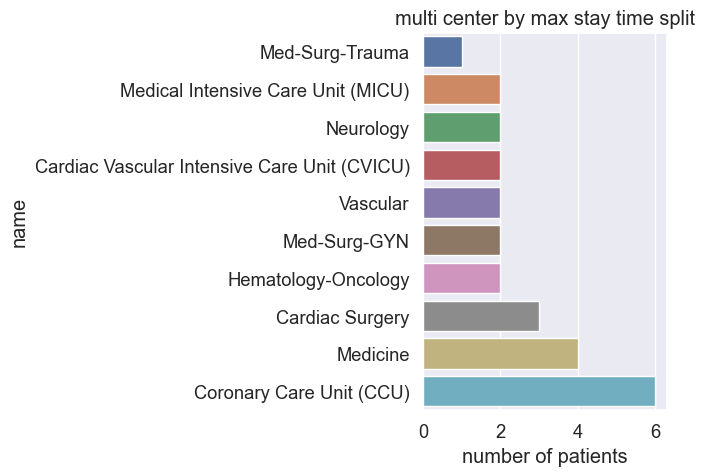

In [75]:
show_centers_statistics(dir_path='data/icd10-multi-center/split_by_max_stay_time/', title_split_name='max stay time')


The number of centers is=14
The names of the centers: dict_keys(['Cardiac Surgery', 'Coronary Care Unit (CCU)', 'Hematology-Oncology Intermediate', 'Hematology-Oncology', 'Med-Surg-GYN', 'Medical Intensive Care Unit (MICU)', 'Medicine-Cardiology Intermediate', 'Medicine-Cardiology', 'Medicine', 'Neuro Stepdown', 'Neurology', 'Transplant', 'Trauma SICU (TSICU)', 'Vascular'])


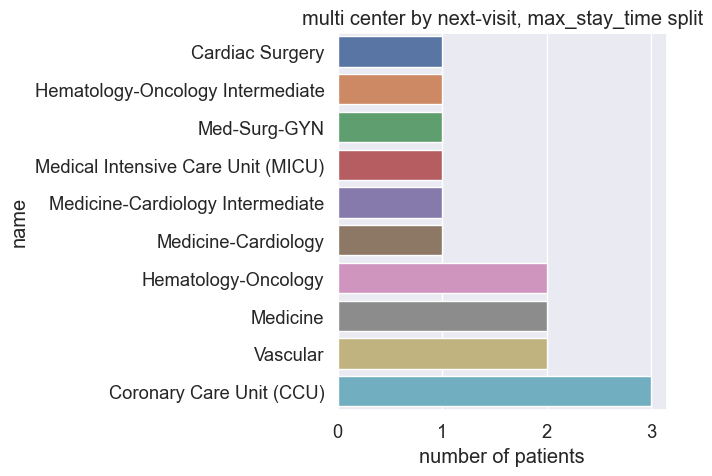

In [76]:
show_centers_statistics(dir_path='data/icd10-multi-center/BEHRT_format/next_visit/split_by_max_stay_time/', title_split_name='next-visit, max_stay_time')